In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,  VotingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## LOAD AND EXPLOR DATASET
Project is aimed at correctly classifying those that will recieve loan and pay back

In [5]:
loan = pd.read_csv('loan.csv')
loan.head(10)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,3,13,0
1,2,7574516,40,10,single,rented,no,9,13,0
2,3,3991815,66,4,married,rented,no,4,10,0
3,4,6256451,41,2,single,rented,yes,2,12,1
4,5,5768871,47,11,single,rented,no,3,14,1
5,6,6915937,64,0,single,rented,no,0,12,0
6,7,3954973,58,14,married,rented,no,8,12,0
7,8,1706172,33,2,single,rented,no,2,14,0
8,9,7566849,24,17,single,rented,yes,11,11,0
9,10,8964846,23,12,single,rented,no,5,13,0


In [6]:
loan.tail()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
251995,251996,8154883,43,13,single,rented,no,6,11,0
251996,251997,2843572,26,10,single,rented,no,6,11,0
251997,251998,4522448,46,7,single,rented,no,7,12,0
251998,251999,6507128,45,0,single,rented,no,0,10,0
251999,252000,9070230,70,17,single,rented,no,7,11,0


In [7]:
loan.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


Text(0.5, 1.0, 'Little Visualization of the dataset')

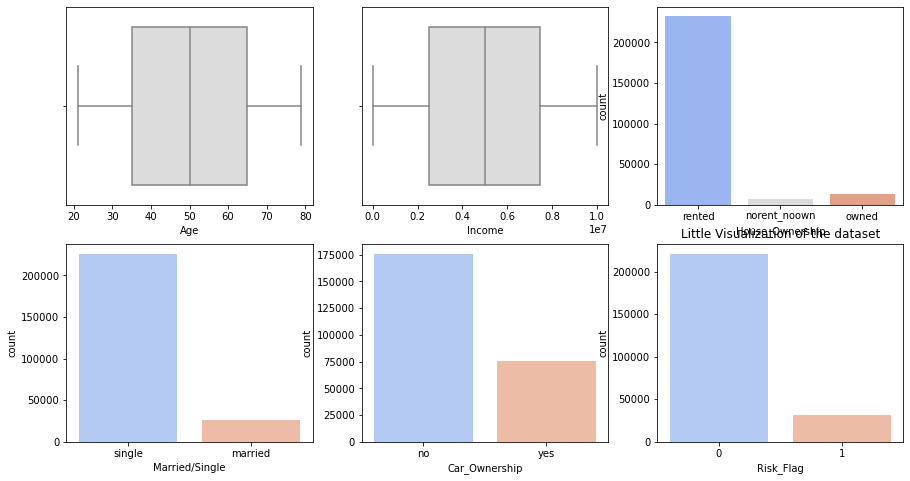

In [15]:
fig, axs = plt.subplots(2,3, figsize = (15,8))
sns.boxplot(ax = axs[0,0], x='Age', palette='coolwarm', data=loan)
sns.boxplot(ax = axs[0,1], x='Income', palette='coolwarm', data=loan)
sns.countplot(ax = axs[0,2], x='House_Ownership', palette='coolwarm', data=loan)
sns.countplot(ax = axs[1,0], x='Married/Single', palette='coolwarm', data=loan)
sns.countplot(ax = axs[1,1], x='Car_Ownership', palette='coolwarm', data=loan)
sns.countplot(ax = axs[1,2], x='Risk_Flag', palette='coolwarm', data=loan)
plt.title('Little Visualization of the dataset')

In [16]:
loan['Married/Single'].replace(['single', 'married'], [0,1], inplace=True)
loan['Marital_status'] = loan['Married/Single']
loan['House_Ownership'].replace(['norent_noown', 'rented', 'owned'], [0,1,2], inplace=True)
loan['Car_Ownership'].replace(['no', 'yes'], [0,1], inplace=True)

In [17]:
lookup_Marital_status = dict(zip(['single', 'married'], [0,1]))
lookup_House_Ownership = dict(zip(['norent_noown', 'rented', 'owned'], [0,1,2]))
lookup_Car_Ownership = dict(zip(['norent_noown', 'rented', 'owned'], [0,1,2]))
lookup_Car_Ownership

{'norent_noown': 0, 'rented': 1, 'owned': 2}

In [18]:
loan = loan.drop(columns=['Id', 'CURRENT_HOUSE_YRS','Married/Single'])
loan

,Income,Age,Experience,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,Risk_Flag,Marital_status
0,1303834,23,3,1,0,3,0,0
1,7574516,40,10,1,0,9,0,0
2,3991815,66,4,1,0,4,0,1
3,6256451,41,2,1,1,2,1,0
4,5768871,47,11,1,0,3,1,0
...,...,...,...,...,...,...,...,...
251995,8154883,43,13,1,0,6,0,0
251996,2843572,26,10,1,0,6,0,0
251997,4522448,46,7,1,0,7,0,0
251998,6507128,45,0,1,0,0,0,0


In [21]:
X = loan.drop(columns=['Risk_Flag'], axis=1).values
X

array([[1303834,      23,       3, ...,       0,       3,       0],
       [7574516,      40,      10, ...,       0,       9,       0],
       [3991815,      66,       4, ...,       0,       4,       1],
       ...,
       [4522448,      46,       7, ...,       0,       7,       0],
       [6507128,      45,       0, ...,       0,       0,       0],
       [9070230,      70,      17, ...,       0,       7,       0]],
      dtype=int64)

In [22]:
y = loan[['Risk_Flag']].values
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

## SPLIT DATASET FOR TRAINING AND TESTING

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=45)

## Design Goal
Model that predicts all risky loans that is when risk_flag = 1

### Selecting the optimal hyperparameters for best perfomance of celected models

In [24]:
models_list = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

In [25]:
model_hyperparameters = {
    
    'KNN_hyp' : {
        'n_neighbors' : [8,10,12,14]
    },
    'dec_tree_hyp' : {
        'max_depth' : [6,8,9,10],
    },
    'random_forest_hyp' : {
        'n_estimators' : [500, 600,700,800],
        'max_features' : [2,3]
    }
}

In [26]:
model_keys= list(model_hyperparameters.keys())
print(model_keys)

['KNN_hyp', 'dec_tree_hyp', 'random_forest_hyp']


In [27]:
def model_selection(list_of_models,hyperparametrs_dictionary):
    
    result = []
    i = 0
    
    for model in list_of_models:
        key = model_keys[i]
        params = hyperparametrs_dictionary[key]
        i+=1
        
        print(model)
        print(params)
        print('---------------------------------------------')
        
        classifier = GridSearchCV(model, params, cv=5, scoring='recall')
        
        # fitting the data to classifier
        
        classifier.fit(X,y.ravel())
        result.append({
            'model used': model,
            'highest score' : classifier.best_score_,
            'best hyperparameters': classifier.best_params_
        })
        
    result_dataframe = pd.DataFrame(result, columns=['model used', 'highest score', 'best hyperparameters'])

    return result_dataframe

In [ ]:
model_selection(models_list, model_hyperparameters)

KNeighborsClassifier()
{'n_neighbors': [8, 10, 12, 14]}
---------------------------------------------
DecisionTreeClassifier()
{'max_depth': [6, 8, 9, 10]}
---------------------------------------------
RandomForestClassifier()
{'n_estimators': [500, 600, 700, 800], 'max_features': [2, 3]}
---------------------------------------------


## USING DECISION TREE CLASSIFIER ALGORITHM

In [15]:
dtc = DecisionTreeClassifier(random_state=45)

In [16]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=45)

In [17]:
dtc_pred = dtc.predict(X_test)

In [18]:
dtc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### TESTING THE ACCURACY OF THE DTC MODEL

In [19]:
# USING CONFUSION MATRIX
print(confusion_matrix(y_test,dtc_pred))

[[51264  3962]
 [ 3374  4400]]


In [20]:
# USING CLASSIFICATION REPORT
print(classification_report(y_test,dtc_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     55226
           1       0.53      0.57      0.55      7774

    accuracy                           0.88     63000
   macro avg       0.73      0.75      0.74     63000
weighted avg       0.89      0.88      0.89     63000



## USING KNEAREST NEIGHBOR ALGORITHM

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)

In [22]:
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [23]:
knn_pred = knn.predict(X_test)

In [24]:
knn_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### TESTING THE ACCURACY OF KNN MODEL

In [25]:
# USING CONFUSION MATRIX
print(confusion_matrix(y_test,knn_pred))

[[52192  3034]
 [ 3892  3882]]


In [26]:
# USING CLASSIFICATION REPORT
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     55226
           1       0.56      0.50      0.53      7774

    accuracy                           0.89     63000
   macro avg       0.75      0.72      0.73     63000
weighted avg       0.89      0.89      0.89     63000



## USING RANDOM FORREST CLASSIFIER

In [27]:
rfc = RandomForestClassifier(n_estimators=200)

In [28]:
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=200)

In [29]:
rfc_pred = rfc.predict(X_test)

In [30]:
rfc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### TESTING THE ACCURACY OF THE RFC MODEL

In [31]:
# USING CONFUSION MATRIX
print(confusion_matrix(y_test,rfc_pred))

[[52301  2925]
 [ 3577  4197]]


In [32]:
# USING CLASSIFICATION REPORT
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55226
           1       0.59      0.54      0.56      7774

    accuracy                           0.90     63000
   macro avg       0.76      0.74      0.75     63000
weighted avg       0.89      0.90      0.89     63000



## USING VOTING ENSEMBLE TO GET THE BEST MODEL 

In [33]:
estimators = [("decision",dtc),("KNeighbors", knn), ("Random", rfc)]

In [34]:
vc = VotingClassifier(estimators=estimators, voting="soft")

In [35]:
vc.fit(X_train, y_train.values.ravel())

VotingClassifier(estimators=[('decision',
                              DecisionTreeClassifier(random_state=45)),
                             ('KNeighbors', KNeighborsClassifier()),
                             ('Random',
                              RandomForestClassifier(n_estimators=200))],
                 voting='soft')

In [36]:
vc_pred = vc.predict(X_test)

In [37]:
vc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
# USING CLASSIFICATION REPORT TO TEST ACCURACY OF VOTING CLASSIFIER
print(classification_report(y_test,vc_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     55226
           1       0.57      0.54      0.56      7774

    accuracy                           0.89     63000
   macro avg       0.76      0.74      0.75     63000
weighted avg       0.89      0.89      0.89     63000



## USING BAGGING ENSEMBLE

In [39]:
bc = BaggingClassifier(base_estimator = dtc, n_estimators=10)

In [40]:
bc.fit(X_train, y_train.values.ravel())

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=45))

In [41]:
bc_pred = bc.predict(X_test)

In [42]:
bc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [54]:
# USING CLASSIFICATION REPORT TO TEST ACCURACY OF BAGGING CLASSIFIER
print(classification_report(y_test,bc_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     55226
           1       0.59      0.54      0.57      7774

    accuracy                           0.90     63000
   macro avg       0.76      0.75      0.75     63000
weighted avg       0.89      0.90      0.90     63000



## USING STACKING ENSEMBLE

In [43]:
from sklearn.ensemble import StackingClassifier

In [44]:
sc = StackingClassifier(estimators=estimators, final_estimator = dtc)

In [45]:
sc.fit(X_train, y_train.values.ravel())

StackingClassifier(estimators=[('decision',
                                DecisionTreeClassifier(random_state=45)),
                               ('KNeighbors', KNeighborsClassifier()),
                               ('Random',
                                RandomForestClassifier(n_estimators=200))],
                   final_estimator=DecisionTreeClassifier(random_state=45))

In [46]:
sc_pred = sc.predict(X_test)

In [59]:
sc_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [47]:
# USING CLASSIFICATION REPORT TO TEST ACCURACY OF STACKING CLASSIFIER
print(classification_report(y_test,sc_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     55226
           1       0.50      0.45      0.47      7774

    accuracy                           0.88     63000
   macro avg       0.71      0.69      0.70     63000
weighted avg       0.87      0.88      0.87     63000



## USING GRADIENT BOOSTING CLASSIFIER

In [48]:
gbc = GradientBoostingClassifier(n_estimators=100)

In [49]:
gbc.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier()

In [50]:
gbc_pred = gbc.predict(X_test)

In [51]:
gbc_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
# USING CLASSIFICATION REPORT TO TEST ACCURACY OF GRADIENT BOOSTING CLASSIFIER
print(classification_report(y_test,gbc_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     55226
           1       0.78      0.00      0.00      7774

    accuracy                           0.88     63000
   macro avg       0.83      0.50      0.47     63000
weighted avg       0.86      0.88      0.82     63000



## USING VOTING ENSEMBLE TO GET THE BEST MODEL

In [53]:
estimators = [("Voting", vc), ("Bagging", bc), ("Stacking", sc), ("Gradient", gbc)]

In [54]:
vc = VotingClassifier(estimators=estimators, voting="hard")

In [55]:
vc.fit(X_train, y_train.values.ravel())

VotingClassifier(estimators=[('Voting',
                              VotingClassifier(estimators=[('decision',
                                                            DecisionTreeClassifier(random_state=45)),
                                                           ('KNeighbors',
                                                            KNeighborsClassifier()),
                                                           ('Random',
                                                            RandomForestClassifier(n_estimators=200))],
                                               voting='soft')),
                             ('Bagging',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=45))),
                             ('Stacking',
                              StackingClassifier(estimators=[('decision',
                                                              DecisionTreeClassifier(random_state=45)),
                      

In [56]:
final_pred = vc.predict(X_test)

In [71]:
final_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [57]:
# USING CLASSIFICATION REPORT TO TEST ACCURACY OF VOTING CLASSIFIER
print(classification_report(y_test,final_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     55226
           1       0.62      0.29      0.39      7774

    accuracy                           0.89     63000
   macro avg       0.76      0.63      0.67     63000
weighted avg       0.87      0.89      0.87     63000



## SAVE TO PICKLE

In [58]:
import pickle

In [59]:
with open("loan.plk", "wb") as f:
    pickle.dump(loan, f, protocol = pickle.HIGHEST_PROTOCOL)